# Pill Identifier Machine Learning Model and API
All pills and tablets have a unique combination of features that allow them to be identified. 
These features are its color, its shape, and imprints made in front and/or at the back of the drug.

This model will utilize [insert model here] for image classification.

[more details to be added]

# Imports, Declarations, and Globals

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt     # to plot charts
import numpy as np
import numba as nb                  # to optimize any mathematics
import pickle as pkl                # to save our model
import sklearn                      # for dataset splitting and metrics
import pandas as pd                 # for data manipulation
# import cv2                          # for image processing
#TODO uncomment when ready

# sklearn imports for metrics and dataset splitting
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# keras imports for image preprocessing
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.utils import to_categorical

# keras imports for model building 

# keras imports for early stoppage and model checkpointing
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torchvision.transforms as transforms

# Helper Functions

# Data Acquisition
Retrieves the images from our dataset and stores them in memory.
Corresponding labels are retrieved, as well.

In [2]:
directory = "dataset"
img_height = 120
img_width = 120
batch_size=32

# read the csv file with labels
csv_file = "table.csv"
df = pd.read_csv(csv_file)

# encode the labels
label_encoder = LabelEncoder()
df["encoded_label"] = label_encoder.fit_transform(df["name"])

# create a dataset from the dataframe
image_paths = df["rxnavImageFileName"].values
labels = df["encoded_label"].values
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# print the first 5 image paths and decoded labels
for image, label in dataset.take(5):
  print("Image:", image.numpy())
  print("Label:", label_encoder.inverse_transform([label.numpy()])[0])
  print()

Image: b'00093-0311-01_RXNAVIMAGE10_26211358.jpg'
Label: Loperamide Hydrochloride 2 MG Oral Capsule

Image: b'00093-3165-01_RXNAVIMAGE10_36231B28.jpg'
Label: Minocycline 50 MG Oral Capsule

Image: b'00093-0810-01_RXNAVIMAGE10_24231228.jpg'
Label: Nortriptyline 10 MG Oral Capsule

Image: b'00093-0811-01_RXNAVIMAGE10_20231018.jpg'
Label: Nortriptyline 25 MG Oral Capsule

Image: b'00093-0812-01_RXNAVIMAGE10_2D2316D8.jpg'
Label: Nortriptyline 50 MG Oral Capsule


In [3]:
def load_images(path, label):
  image = tf.io.read_file(directory + '/' + path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [256, 256])
  image /= 255.0 
  return image, label

dataset = dataset.map(load_images)

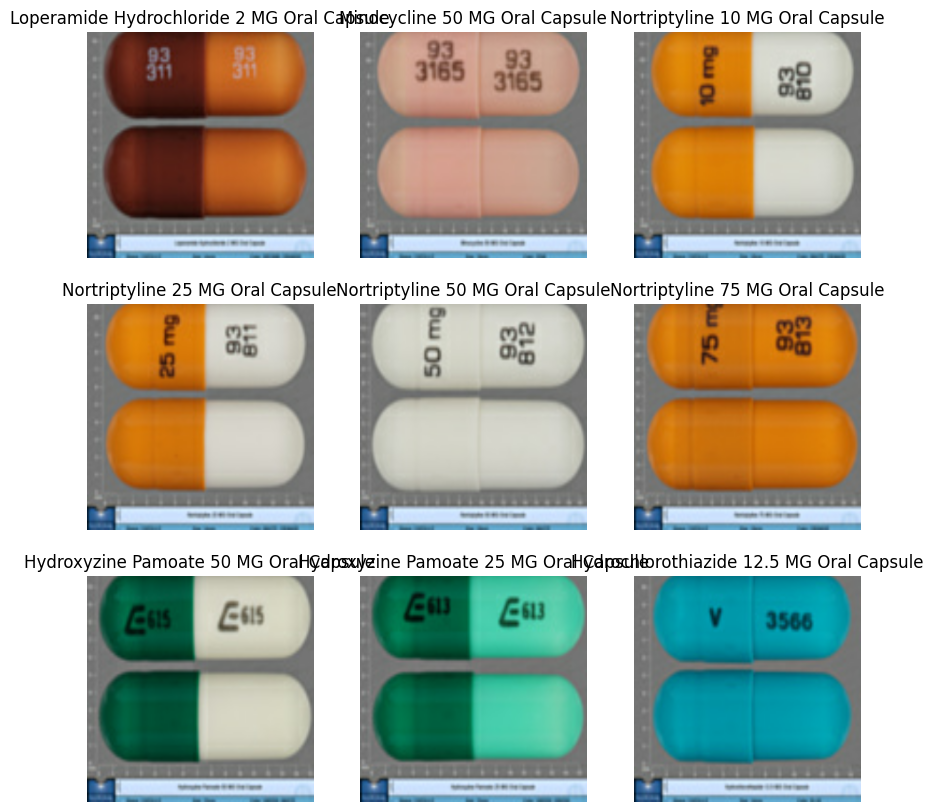

In [ ]:
# display the first 9 images and their labels
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(label_encoder.inverse_transform([label.numpy()])[0])
  plt.axis("off")

# Data Augmentation and Preprocessing
Because each pill/tablet only has one picture, the data set in itself is not ideal.
To improve the quality of the data set, and that of the model, we augment the data.
We do this by transforming the image, mimicking how an actual user may take a picture.
That is, the image can be brightened, resized, rotated, sheared, cropped, and etc. Other processes are also performed to improve training of the model such as splitting the data into a training set and testing set.

In [ ]:
#Splitting dataset into 80/20
training_dataframe, testing_dataframe = train_test_split(dataset_df, test_size = 0.2, random_state = 42)


#Data Geneartion train and test
train_data = ImageDataGenerator(
    rotation_range = 60,
    rescale = 1./255,
    shear_range = 0.3,
    zoom_range = 0.5,
    vertical_flip = True,
    horizontal_flip = True,
    width_shift_range = 0.3,
    height_shift_range = 0.3
)

test_data = ImageDataGenerator(
    rescale = 1./255
)

#Train generation
train_generator = train_data.flow_from_dataframe(
    training_dataframe,
    "dataset",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "filename",
    y_col = "label",
    class_mode="categorical",
)

#Test generation
test_generator = test_data.flow_from_dataframe(
    testing_dataframe,
    "dataset",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    x_col = "filename",
    y_col = "label",
    class_mode="categorical",
)

# Filtering
Using OpenCV, we filter out any artifacts (i.e. background, lens flares, graininess, etc.) and extract the features necessary for identification.

In [ ]:
# apply thresholding to a color image
def thresholding(img):
  # Split the image into the B,G,R components
  b, g, r = cv2.split(img)

  # Apply thresholding to each channel
  _, b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  _, g = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  _, r = cv2.threshold(r, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Merge the channels
  thresholded = cv2.merge([b, g, r])

  return thresholded

# Hyperparameter Search
To ensure the best set of hyperparameters used by the model, we enable hyperparameter search prior to training the model. This exhaustively searches the best combination of hyperparameters to be used for training.


# Model Training
We train the model using the best hyperparameters on the training set.

# Model Testing
We test the model on the test set, to validate training.

# Save the Model
We serialize the model for checkpointing and for later use.

# Predict
Utilizing the model, we predict the label of an image and produce up to five responses with their corresponding relevance scores.